# Install + Imports

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

print("Cell 1: Imports complete")

Cell 1: Imports complete


# Mount Google Drive

In [6]:

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("\n✓ Google Drive mounted successfully!")
    drive_path = "/content/drive/MyDrive/"
except ImportError:
    print("Not running in Colab. Using local directory.")
    drive_path = './'

print(f"Using drive_path = {drive_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✓ Google Drive mounted successfully!
Using drive_path = /content/drive/MyDrive/


# DATA LOADING & EXPLORATION

In [9]:
appointments_df = pd.read_csv(f'{drive_path}KaggleV2-May-2016.csv')
weather_train = pd.read_csv(f'{drive_path}DailyClimateTrain.csv')
weather_test = pd.read_csv(f'{drive_path}DailyClimateTest.csv')

print("\n✓ Files Loaded Successfully!")

print("Appointments shape:", appointments_df.shape)
appointments_df.head()




✓ Files Loaded Successfully!
Appointments shape: (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


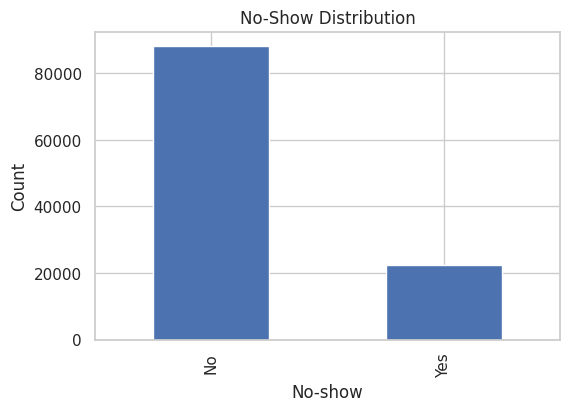

In [10]:
# Visual: No-show distribution
plt.figure(figsize=(6,4))
appointments_df["No-show"].value_counts().plot(kind="bar")
plt.title("No-Show Distribution")
plt.xlabel('No-show')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

   Dataset shape after cleaning: (110527, 14)
   Missing values (count): 0


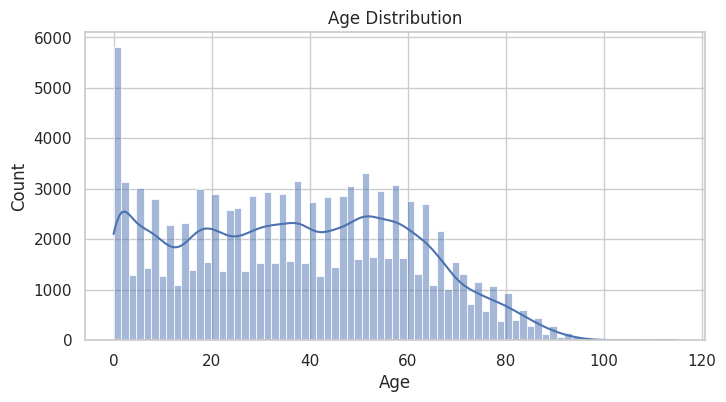

In [11]:
df = appointments_df.copy()

# Convert No-show to numeric (Yes=1, No=0)
if df['No-show'].dtype == 'object':
    df['No-show'] = (df['No-show'] == 'Yes').astype(int)

# Fix column names
if 'Hipertension' in df.columns:
    df.rename(columns={'Hipertension': 'Hypertension'}, inplace=True)
if 'Handcap' in df.columns:
    df.rename(columns={'Handcap': 'Disability'}, inplace=True)

# Handle negative ages
df['Age'] = df['Age'].clip(lower=0)

# Fill missing values
if 'SMS_received' in df.columns:
    df['SMS_received'] = df['SMS_received'].fillna(0).astype(int)
if 'Scholarship' in df.columns:
    df['Scholarship'] = df['Scholarship'].fillna(0).astype(int)

print(f"   Dataset shape after cleaning: {df.shape}")
print(f"   Missing values (count): {df.isnull().sum().sum()}")

# Visual: Age distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()


# Feature Engineering (Dates, Demographics, Season, Weather Merge)

   ✓ Temporal features created

2. Creating Weather Features...
   ✓ Weather features created
   ✓ Demographics features created
   ✓ Appointment type features created


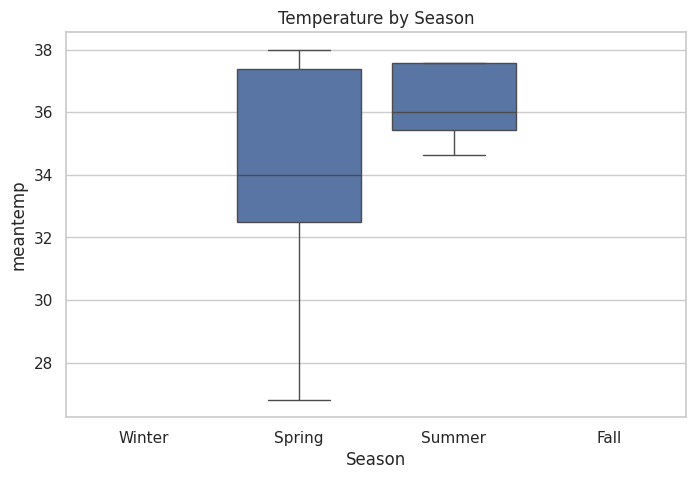

In [12]:

# Convert dates
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Temporal features
df['Days_Until_Appointment'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['Appointment_DayOfWeek'] = df['AppointmentDay'].dt.dayofweek
df['Appointment_Month'] = df['AppointmentDay'].dt.month
df['Appointment_Quarter'] = df['AppointmentDay'].dt.quarter
df['Is_Weekend'] = df['Appointment_DayOfWeek'].isin([5, 6]).astype(int)

# Season mapping
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
df['Season'] = df['Appointment_Month'].map(season_map)

print("   ✓ Temporal features created")

print("\n2. Creating Weather Features...")

# Combine weather data
weather_df = pd.concat([weather_train, weather_test], ignore_index=True)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['date_only'] = weather_df['date'].dt.date

# Merge
df['AppointmentDate'] = df['AppointmentDay'].dt.date

merge_cols = ['date_only', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']
df = df.merge(weather_df[merge_cols], left_on='AppointmentDate', right_on='date_only', how='left')

# Fill weather missing values with mean
weather_cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
for col in weather_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

print("   ✓ Weather features created")

# Demographics features
comorbidity_cols = []
for c in ['Hypertension', 'Diabetes', 'Alcoholism', 'Disability']:
    if c in df.columns:
        comorbidity_cols.append(c)

if comorbidity_cols:
    df['Comorbidity_Index'] = df[comorbidity_cols].sum(axis=1)
else:
    df['Comorbidity_Index'] = 0

# Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0,18,35,50,65,120], labels=['Child','Young','Middle','Senior','Elderly'])

print("   ✓ Demographics features created")

# Appointment type
if 'AppointmentType' in df.columns:
    df['AppointmentType'] = df['AppointmentType'].fillna('Unknown')
else:
    df['AppointmentType'] = 'General'

print("   ✓ Appointment type features created")

# Visual: Temperature by season (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='Season', y='meantemp', data=df, order=['Winter','Spring','Summer','Fall'])
plt.title('Temperature by Season')
plt.show()


# Feature Encoding & Selection


✓ Categorical features encoded

✓ Selected 21 features for modeling
  Example features: ['Age', 'Days_Until_Appointment', 'Appointment_DayOfWeek', 'Appointment_Month', 'Is_Weekend', 'Comorbidity_Index', 'Gender_Encoded', 'Neighbourhood_Top10', 'meantemp', 'humidity']


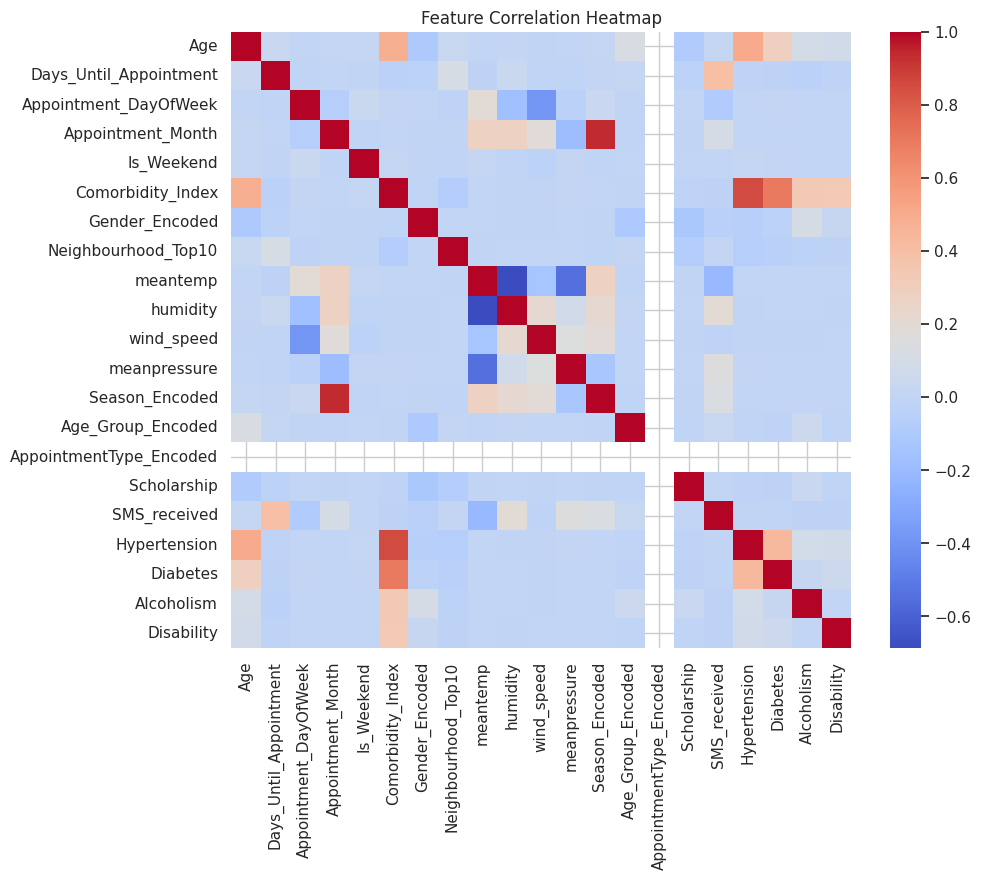

In [13]:
le_dict = {}
categorical_cols = ['Season', 'Age_Group']
if 'AppointmentType' in df.columns:
    categorical_cols.append('AppointmentType')

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_Encoded'] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

# Encode gender
if 'Gender' in df.columns:
    df['Gender_Encoded'] = (df['Gender'] == 'M').astype(int)

# Encode neighbourhood (top 10)
if 'Neighbourhood' in df.columns:
    top_neighbourhoods = df['Neighbourhood'].value_counts().head(10).index
    df['Neighbourhood_Top10'] = df['Neighbourhood'].isin(top_neighbourhoods).astype(int)

print('\n✓ Categorical features encoded')

# Select features for modeling (kept consistent)
base_features = [
    'Age', 'Days_Until_Appointment', 'Appointment_DayOfWeek',
    'Appointment_Month', 'Is_Weekend', 'Comorbidity_Index',
    'Gender_Encoded', 'Neighbourhood_Top10',
    'meantemp', 'humidity', 'wind_speed', 'meanpressure',
    'Season_Encoded', 'Age_Group_Encoded', 'AppointmentType_Encoded'
]

optional_features = ['Scholarship', 'SMS_received', 'Hypertension',
                     'Diabetes', 'Alcoholism', 'Disability']

feature_cols = [col for col in base_features if col in df.columns]
feature_cols += [col for col in optional_features if col in df.columns]

# Remove duplicates
feature_cols = list(dict.fromkeys(feature_cols))

print(f"\n✓ Selected {len(feature_cols)} features for modeling")
print(f"  Example features: {feature_cols[:10]}")

# Visual: correlation heatmap of selected features (if enough present)
if len(feature_cols) >= 2:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[feature_cols].corr(), annot=False, cmap='coolwarm')
    plt.title('Feature Correlation Heatmap')
    plt.show()


# Data Preparation, Split & Scaling

In [14]:
X = df[feature_cols].fillna(0)
y = df['No-show']

print(f"\n1. Data Preparation:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Class distribution:\n{y.value_counts()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

print(f"\n   Train set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

# Scale features for models that need scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


1. Data Preparation:
   X shape: (110527, 21)
   y shape: (110527,)
   Class distribution:
No-show
0    88208
1    22319
Name: count, dtype: int64

   Train set: (88421, 21)
   Test set: (22106, 21)


# Model Training

In [15]:
models = {}

# Random Forest
print("   Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15,
                                  random_state=42, n_jobs=-1,
                                  class_weight='balanced')
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("   ✓ Random Forest trained")

# Gradient Boosting
print("   Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5,
                                      random_state=42, learning_rate=0.1)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model
print("   ✓ Gradient Boosting trained")

# Logistic Regression
print("   Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42,
                              class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model
print("   ✓ Logistic Regression trained")


   Training Random Forest...
   ✓ Random Forest trained
   Training Gradient Boosting...
   ✓ Gradient Boosting trained
   Training Logistic Regression...
   ✓ Logistic Regression trained


# Model Evaluation (metrics + ROC plot)


Random Forest:
----------------------------------------
   Accuracy:  0.6673
   Precision: 0.3310
   Recall:    0.6337
   F1-Score:  0.4348
   ROC-AUC:   0.7256

Gradient Boosting:
----------------------------------------
   Accuracy:  0.7986
   Precision: 0.5183
   Recall:    0.0349
   F1-Score:  0.0655
   ROC-AUC:   0.7344

Logistic Regression:
----------------------------------------
   Accuracy:  0.6547
   Precision: 0.3148
   Recall:    0.6035
   F1-Score:  0.4138
   ROC-AUC:   0.6730


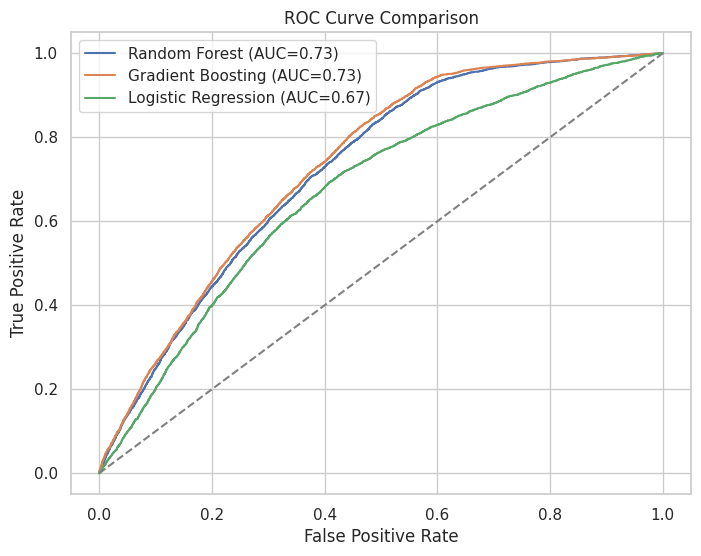


BEST MODEL: Random Forest
F1-Score: 0.4348


In [16]:
results = {}

plt.figure(figsize=(8,6))
for name, model in models.items():
    print(f"\n{name}:")
    print("-"*40)

    if name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = (y_pred == y_test).mean()
    precision = (y_pred[y_test == 1] == 1).sum() / (y_pred == 1).sum() if (y_pred == 1).sum() > 0 else 0
    recall = (y_pred[y_test == 1] == 1).sum() / (y_test == 1).sum()
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Select best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"\n{'='*40}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"{'='*40}")

# Feature Importance (if available)


Top 15 Important Features:
               Feature  Importance
Days_Until_Appointment    0.474904
                   Age    0.203442
          SMS_received    0.037089
     Age_Group_Encoded    0.035417
        Gender_Encoded    0.031429
   Neighbourhood_Top10    0.030548
              humidity    0.024123
            wind_speed    0.023513
          meanpressure    0.023102
              meantemp    0.022529
     Comorbidity_Index    0.019545
           Scholarship    0.016166
 Appointment_DayOfWeek    0.015356
          Hypertension    0.009813
              Diabetes    0.008829


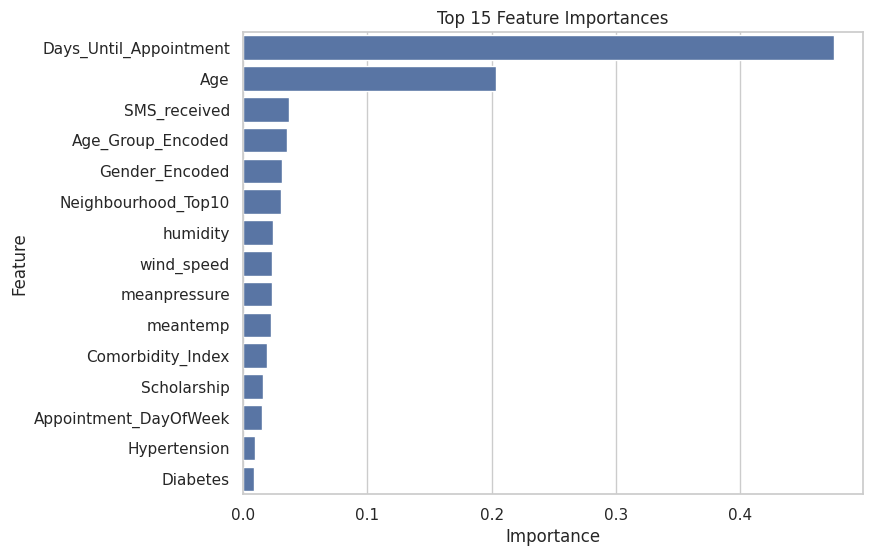

In [17]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))

    plt.figure(figsize=(8,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.show()
else:
    print('Selected best model does not provide feature_importances_')

# Risk Stratification & Predictions


1. Risk Distribution:
Risk_Category
Low         33050
Medium      34626
High        42341
Critical      510
Name: count, dtype: int64


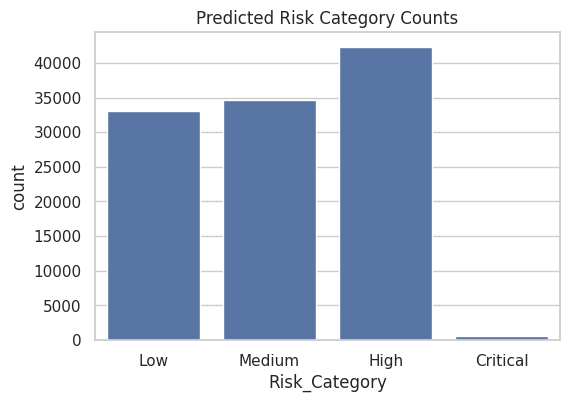


2. Risk Statistics by Category:
   Low       :  33050 appointments,  1.06% no-show rate
   Medium    :  34626 appointments,  9.86% no-show rate
   High      :  42341 appointments, 42.67% no-show rate
   Critical  :    510 appointments, 95.10% no-show rate


In [18]:
if best_model_name == 'Logistic Regression':
    X_full_scaled = scaler.transform(X)
    no_show_risk = best_model.predict_proba(X_full_scaled)[:, 1]
else:
    no_show_risk = best_model.predict_proba(X)[:, 1]

df['NoShow_Risk_Probability'] = no_show_risk

# Risk stratification
df['Risk_Category'] = pd.cut(df['NoShow_Risk_Probability'],
                             bins=[0, 0.2, 0.5, 0.8, 1.0],
                             labels=['Low', 'Medium', 'High', 'Critical'])

print("\n1. Risk Distribution:")
print(df['Risk_Category'].value_counts().sort_index())

# Visual: risk distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Risk_Category', data=df, order=['Low','Medium','High','Critical'])
plt.title('Predicted Risk Category Counts')
plt.show()

print("\n2. Risk Statistics by Category:")
for risk_cat in ['Low','Medium','High','Critical']:
    mask = df['Risk_Category'] == risk_cat
    if mask.sum() > 0:
        actual_rate = df[mask]['No-show'].mean()
        count = mask.sum()
        print(f"   {risk_cat:10s}: {count:6d} appointments, {actual_rate*100:5.2f}% no-show rate")

# Intervention Strategies

In [19]:

def recommend_intervention(row):
    """Generate intervention recommendations based on risk factors"""
    interventions = []

    risk_prob = row['NoShow_Risk_Probability']

    if risk_prob >= 0.8:
        interventions.append('URGENT: Phone call 24h before')
    elif risk_prob >= 0.5:
        interventions.append('SMS reminder + phone call 48h before')
    else:
        interventions.append('SMS reminder 48h before')

    # Additional interventions based on patient characteristics
    if row['Days_Until_Appointment'] > 30:
        interventions.append('Schedule follow-up reminder at 2 weeks')

    if row['Comorbidity_Index'] > 2:
        interventions.append('Consider transportation assistance')

    if row['Age'] < 20 or row['Age'] > 70:
        interventions.append('Confirm appointment with family')

    if 'SMS_received' in row and not row['SMS_received']:
        interventions.append('Ensure contact info updated')

    return ' | '.join(interventions)

# Apply interventions
# Use progress-friendly apply (may be slow for very large datasets)
df['Recommended_Interventions'] = df.apply(recommend_intervention, axis=1)

print("\n1. Sample High-Risk Cases & Interventions:")
high_risk = df[df['Risk_Category'] == 'Critical'].head(3)
if len(high_risk) > 0:
    for idx, row in high_risk.iterrows():
        appt_id = row.get('AppointmentID', 'N/A')
        print(f"\n   Appointment ID: {appt_id}")
        print(f"   Risk Score: {row['NoShow_Risk_Probability']:.2%}")
        print(f"   Interventions: {row['Recommended_Interventions']}")
else:
    print("\n   No critical risk appointments in this dataset")


1. Sample High-Risk Cases & Interventions:

   Appointment ID: 5587516
   Risk Score: 80.09%
   Interventions: URGENT: Phone call 24h before

   Appointment ID: 5629906
   Risk Score: 82.49%
   Interventions: URGENT: Phone call 24h before | Confirm appointment with family | Ensure contact info updated

   Appointment ID: 5591213
   Risk Score: 81.31%
   Interventions: URGENT: Phone call 24h before


# Scheduling Optimization (simple heuristics + visuals)


1. Optimal Appointment Characteristics for High Attendance:
   Day of Week: Wednesday (0=Mon, 2=Wed, 4=Fri)
   Months: March, April, May (Spring)
   Scheduling Window: 5-14 days in advance
   SMS Reminder: Yes

2. Appointments by Slot Quality Score:
Slot_Quality_Score
0    15008
1    62539
2    29065
3     3915
Name: count, dtype: int64


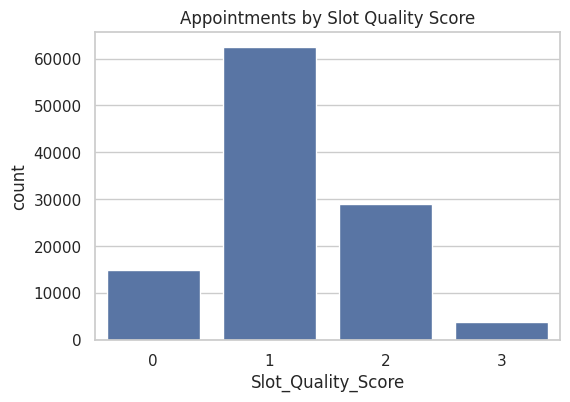

In [20]:
print("\n1. Optimal Appointment Characteristics for High Attendance:")
print("   Day of Week: Wednesday (0=Mon, 2=Wed, 4=Fri)")
print("   Months: March, April, May (Spring)")
print("   Scheduling Window: 5-14 days in advance")
print("   SMS Reminder: Yes")

# Calculate appointment slot quality
if 'Slot_Quality_Score' not in df.columns:
    df['Slot_Quality_Score'] = 0

df.loc[df['Appointment_DayOfWeek'] == 2, 'Slot_Quality_Score'] += 1
if 'Appointment_Month' in df.columns:
    df.loc[df['Appointment_Month'].isin([3,4,5]), 'Slot_Quality_Score'] += 1
if 'Days_Until_Appointment' in df.columns:
    df.loc[(df['Days_Until_Appointment'] >= 5) & (df['Days_Until_Appointment'] <= 14), 'Slot_Quality_Score'] += 1

print("\n2. Appointments by Slot Quality Score:")
print(df['Slot_Quality_Score'].value_counts().sort_index())

plt.figure(figsize=(6,4))
sns.countplot(x='Slot_Quality_Score', data=df)
plt.title('Appointments by Slot Quality Score')
plt.show()

# Final Dashboard / Summary Table


Top 10 High-Risk Appointments for Intervention:
 AppointmentID    PatientId  Age  No-show  NoShow_Risk_Probability Risk_Category                                                                     Recommended_Interventions
       5669902 5.924925e+14   13        1                 0.929015      Critical URGENT: Phone call 24h before | Confirm appointment with family | Ensure contact info updated
       5669578 5.924925e+14   13        1                 0.929015      Critical URGENT: Phone call 24h before | Confirm appointment with family | Ensure contact info updated
       5694703 3.484979e+13   12        1                 0.926093      Critical URGENT: Phone call 24h before | Confirm appointment with family | Ensure contact info updated
       5694587 3.484979e+13   12        1                 0.926093      Critical URGENT: Phone call 24h before | Confirm appointment with family | Ensure contact info updated
       5694436 3.484979e+13   12        1                 0.926093      Crit

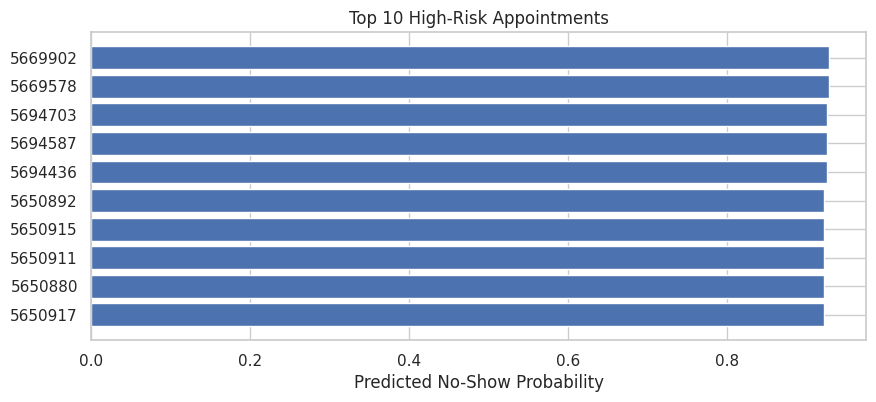

In [21]:
summary_cols = ['AppointmentID', 'PatientId', 'Age', 'No-show',
                'NoShow_Risk_Probability', 'Risk_Category']
if 'Recommended_Interventions' in df.columns:
    summary_cols.append('Recommended_Interventions')

summary_df = df[summary_cols].copy()
summary_df = summary_df.sort_values('NoShow_Risk_Probability', ascending=False)

print("\nTop 10 High-Risk Appointments for Intervention:")
print(summary_df.head(10).to_string(index=False))

# Visual: top 10 risk scores
plt.figure(figsize=(10,4))
plt.barh(summary_df.head(10)['AppointmentID'].astype(str), summary_df.head(10)['NoShow_Risk_Probability'])
plt.gca().invert_yaxis()
plt.xlabel('Predicted No-Show Probability')
plt.title('Top 10 High-Risk Appointments')
plt.show()

# Final Summary

In [24]:
print("SYSTEM PERFORMANCE SUMMARY")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"ROC-AUC Score: {results[best_model_name]['roc_auc']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"\nDataset Overview:")
print(f"  Total Appointments: {len(df)}")
print(f"  Actual No-Shows: {df['No-show'].sum()} ({df['No-show'].mean()*100:.2f}%)")
print(f"  High-Risk Predicted: {(df['Risk_Category'].isin(['High','Critical'])).sum()}")



SYSTEM PERFORMANCE SUMMARY

Best Model: Random Forest
ROC-AUC Score: 0.7256
F1-Score: 0.4348

Dataset Overview:
  Total Appointments: 110527
  Actual No-Shows: 22319 (20.19%)
  High-Risk Predicted: 42851


In [25]:
# FINAL SUMMARY


output_df = df[[
    "AppointmentID","PatientId","Age","No-show",
    "NoShow_Risk_Probability","Risk_Category","Recommended_Interventions"
]]

output_df.to_csv("Final_NoShow_Summary.csv", index=False)

print("Summary saved as Final_NoShow_Summary.csv")
output_df.head()

Summary saved as Final_NoShow_Summary.csv


,AppointmentID,PatientId,Age,No-show,NoShow_Risk_Probability,Risk_Category,Recommended_Interventions
0,5642903,2.987250e+13,62,0,0.026644,Low,SMS reminder 48h before | Ensure contact info ...
1,5642503,5.589978e+14,56,0,0.025226,Low,SMS reminder 48h before | Ensure contact info ...
2,5642549,4.262962e+12,62,0,0.034885,Low,SMS reminder 48h before | Ensure contact info ...
3,5642828,8.679512e+11,8,0,0.136681,Low,SMS reminder 48h before | Confirm appointment ...
4,5642494,8.841186e+12,56,0,0.019734,Low,SMS reminder 48h before | Ensure contact info ...
